## Importing Necessary Libraries


In [1]:
import cv2

import json

import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelEncoder

## Function to Process UI Image and Detect Components


In [2]:
def process_ui_image(image_path):

    # Load the color image

    image = cv2.imread(image_path)

    # Check if the image was loaded properly

    if image is None:

        print(f"Error: Could not load image at {image_path}")

        return None, None, None, None  # Return four None values


    # Apply Gaussian Blur to reduce noise

    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Convert the image to grayscale for edge detection

    gray_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection

    edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)

    # Find contours

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image to draw contours

    final_image = image.copy()

    detected_components = []


    for contour in contours:

        area = cv2.contourArea(contour)

        if area > 100:  # Filter out small areas

            x, y, w, h = cv2.boundingRect(contour)

            detected_components.append((x, y, w, h))  # Store bounding box coordinates

            cv2.rectangle(final_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box

    return final_image, gray_image, edges, detected_components


## Load and Preprocess Training Data


In [3]:
def load_and_preprocess_images(folder_path):

    images = []

    for filename in os.listdir(folder_path):

        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):  # Add other formats as needed

            img_path = os.path.join(folder_path, filename)

            img = cv2.imread(img_path)

            if img is not None:  # Check if the image was successfully loaded

                img_resized = cv2.resize(img, (32, 32))  # Resize image to 128x128

                img_normalized = img_resized.astype(np.float32) / 255.0  # Normalize image to [0, 1]

                images.append(img_normalized)

    return np.array(images)

## Extract Class Labels from Filenames


In [4]:
def extract_labels_from_filenames(folder_path):

    class_labels = []

    for filename in os.listdir(folder_path):

        label = filename.split('-')[-1].split('.')[2]  # Extract class label from filename

        component_name = label.split('.')[-1]  # Get the last part of the label

        class_labels.append(component_name)

    return class_labels

## Load and preprocess the data (images and labels)

In [5]:
def load_data(folder_path):

    # Load images

    images = load_and_preprocess_images(folder_path)

    

    # Extract labels

    class_labels = extract_labels_from_filenames(folder_path)

    

    # Encode labels

    encoder = LabelEncoder()

    encoded_labels = encoder.fit_transform(class_labels)

    num_classes = len(encoder.classes_)

    

    print(f"Loaded {len(images)} images with shape: {images.shape}")

    print(f"Encoded labels: {encoded_labels}...")  # Show a sample of encoded labels

    print(f"Unique classes: {encoder.classes_}")

    print(f"Number of unique classes: {num_classes}")

    print(f"Length of encoded_labels: {len(encoded_labels)}")

    

    return images, encoded_labels, encoder

## Load training data

In [6]:
train_folder_path = '/kaggle/input/redraw-dataset/CNN-Data-Final/CNN-Evaluation/Partitioned-Organic-Data-Split/Training_Sampled'

train_images, train_labels, label_encoder = load_data(train_folder_path)

Loaded 30518 images with shape: (30518, 32, 32, 3)
Encoded labels: [ 0  3  5 ...  4  3 15]...
Unique classes: ['Button' 'CheckBox' 'CheckedTextView' 'EditText' 'ImageButton'
 'ImageView' 'NumberPicker' 'ProgressBarHorizontal' 'ProgressBarVertical'
 'RadioButton' 'RatingBar' 'SeekBar' 'Spinner' 'Switch' 'TextView'
 'ToggleButton']
Number of unique classes: 16
Length of encoded_labels: 30518


## Load validation data

In [7]:
validation_folder_path = '/kaggle/input/redraw-dataset/CNN-Data-Final/CNN-Evaluation/Partitioned-Organic-Data-Split/Validation'

validation_images, validation_labels, _ = load_data(validation_folder_path)

Loaded 28617 images with shape: (28617, 32, 32, 3)
Encoded labels: [14 14 14 ...  0 14 14]...
Unique classes: ['Button' 'CheckBox' 'CheckedTextView' 'EditText' 'ImageButton'
 'ImageView' 'NumberPicker' 'ProgressBarHorizontal' 'ProgressBarVertical'
 'RadioButton' 'RatingBar' 'SeekBar' 'Spinner' 'Switch' 'TextView'
 'ToggleButton']
Number of unique classes: 16
Length of encoded_labels: 57234


## Load test data

In [8]:
test_folder_path = '/kaggle/input/redraw-dataset/CNN-Data-Final/CNN-Evaluation/Partitioned-Organic-Data-Split/Test'

test_images, test_labels, _ = load_data(test_folder_path)

Loaded 19086 images with shape: (19086, 32, 32, 3)
Encoded labels: [14  5 14 ... 14  0 14]...
Unique classes: ['Button' 'CheckBox' 'CheckedTextView' 'EditText' 'ImageButton'
 'ImageView' 'NumberPicker' 'ProgressBarHorizontal' 'ProgressBarVertical'
 'RadioButton' 'RatingBar' 'SeekBar' 'Spinner' 'Switch' 'TextView'
 'ToggleButton']
Number of unique classes: 16
Length of encoded_labels: 38172


## Encode class labels

In [9]:
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)

val_labels_encoded = label_encoder.transform(validation_labels)

test_labels_encoded = label_encoder.transform(test_labels)

## Create the CNN model

In [10]:
def create_cnn_model(input_shape, num_classes):

    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu')(inputs)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)

    x = Dense(16, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax')(x)



    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (32, 32, 3)  # Input image shape

num_classes = len(label_encoder.classes_)  # Number of unique classes in the dataset

model = create_cnn_model(input_shape, num_classes)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,728 (397.38 KB)

 Trainable params: 101,728 (397.38 KB)

 Non-trainable params: 0 (0.00 B)

## Train the CNN Model

In [14]:
history = model.fit(

    train_images, train_labels_encoded,

    epochs=30,

    batch_size=4,

    validation_data=(validation_images, val_labels_encoded),

    verbose=1,

)

Epoch 1/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6630 - loss: 1.0721 - val_accuracy: 0.2871 - val_loss: 2.7865
Epoch 2/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6999 - loss: 0.9391 - val_accuracy: 0.3100 - val_loss: 3.2795
Epoch 3/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.7304 - loss: 0.8447 - val_accuracy: 0.2979 - val_loss: 3.2506
Epoch 4/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.7447 - loss: 0.7882 - val_accuracy: 0.2691 - val_loss: 3.4746
Epoch 5/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.7620 - loss: 0.7386 - val_accuracy: 0.2703 - val_loss: 3.5599
Epoch 6/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.7769 - loss: 0.6811 - val_accuracy: 0.2925 - val_loss: 4.2905
Epoch 7/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7900 - loss: 0.6305 - val_accuracy: 0.2868 - val_loss: 4.5168
Epoch 8/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.8017 - loss: 0

In [16]:
print(len(train_images), len(train_labels_encoded))

print(len(validation_images), len(val_labels_encoded))

print(len(test_images), len(test_labels_encoded))

if len(val_labels_encoded) == 2 * len(validation_images):

    print("Potential duplication detected in val_labels_encoded")

if len(test_labels_encoded) == 2 * len(test_images):

    print("Potential duplication detected in test_labels_encoded")


30518 30518
28617 28617
19086 19086


## Plotting

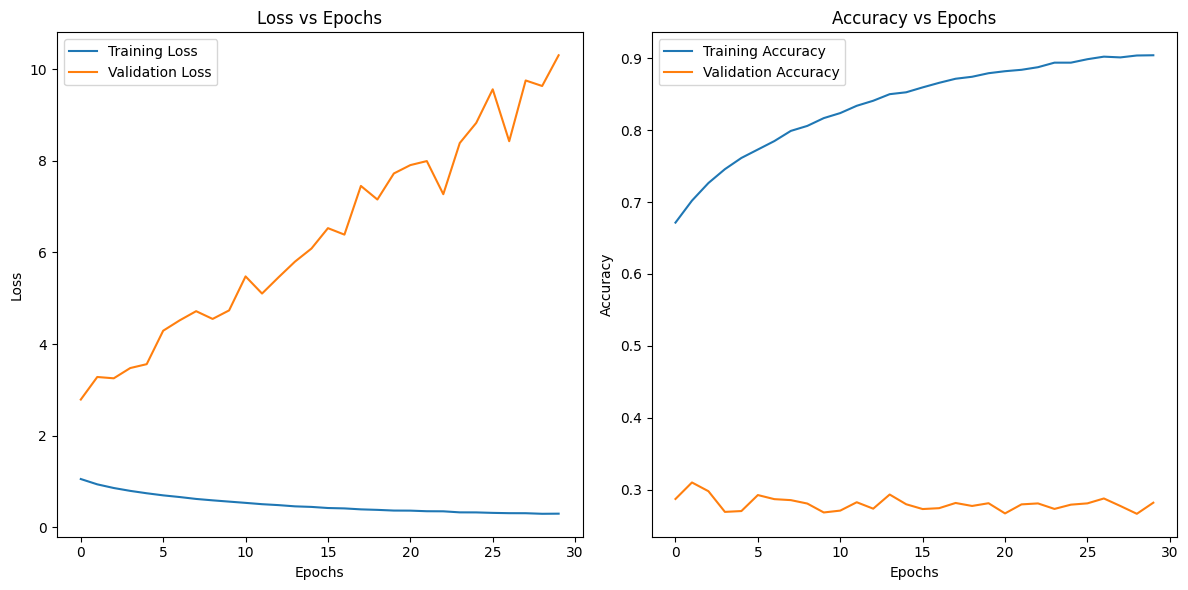

In [33]:
# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# Assuming validation_images, val_labels_encoded, test_images, and test_labels_encoded are lists or arrays

# For validation set
if len(validation_images) != len(val_labels_encoded):
    min_length = min(len(validation_images), len(val_labels_encoded))
    validation_images = validation_images[:min_length]
    val_labels_encoded = val_labels_encoded[:min_length]

# For test set
if len(test_images) != len(test_labels_encoded):
    min_length = min(len(test_images), len(test_labels_encoded))
    test_images = test_images[:min_length]
    test_labels_encoded = test_labels_encoded[:min_length]

# Print the new lengths to verify the adjustment
print(len(validation_images), len(val_labels_encoded))
print(len(test_images), len(test_labels_encoded))


28617 28617
19086 19086


## Evaluate the model on the test data

In [18]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)

test_error = 1 - test_accuracy



print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

print(f"Test Error: {test_error * 100:.2f}%")

597/597 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2827 - loss: 10.5614
Test Accuracy: 28.15%
Test Error: 71.85%


## Evaluate the model on the validation data

In [20]:
validation_loss, validation_accuracy = model.evaluate(validation_images, val_labels_encoded)

validation_error = 1 - validation_accuracy



print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

print(f"Validation Error: {validation_error * 100:.2f}%")

895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2840 - loss: 10.3790
Validation Accuracy: 28.19%
Validation Error: 71.81%


## Make Predictions on Test Data


In [23]:
def predict_on_test_data(test_images):

    # Predict labels for the test images
    predictions = model.predict(test_images)

    # Get the predicted class labels
    predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
    return predicted_labels

# Predict labels for the test data

predicted_test_labels = predict_on_test_data(test_images)



# Print some sample predictions

print("Sample predictions on test data:", predicted_test_labels[:5])

597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Sample predictions on test data: [14  3  0 14 14]


## Generate Confusion Matrix

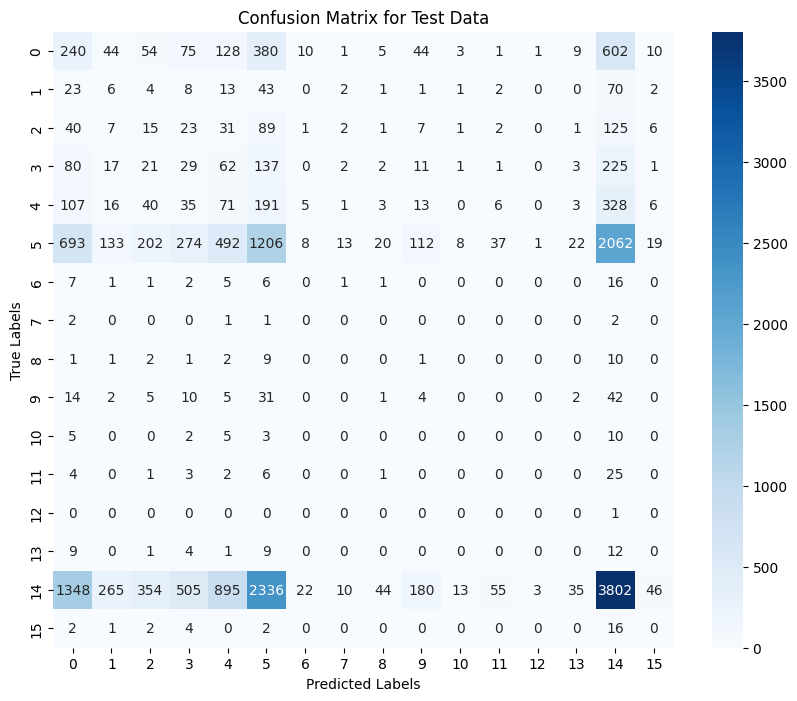

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have encoded test labels: test_labels_encoded
# Generate confusion matrix for the test data
cm = confusion_matrix(test_labels_encoded, predicted_test_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


## Classify UI Components in a New Image

In [ ]:
def classify_ui_components(image_path, model, encoder):

    processed_image, _, _, detected_components = process_ui_image(image_path)



    if processed_image is None:

        return None, None, None



    # Prepare images for classification

    component_images = []

    for (x, y, w, h) in detected_components:

        component_img = processed_image[y:y+h, x:x+w]

        component_img_resized = cv2.resize(component_img, (128, 128))  # Resize for CNN

        component_images.append(component_img_resized)



    if len(component_images) == 0:

        print("No components detected.")

        return [], detected_components, processed_image



    # Convert list of component images to a numpy array

    component_images_array = np.array(component_images, dtype=np.float32) / 255.0  # Normalize



    # Predict labels for each component

    predictions = model.predict(component_images_array)

    predicted_labels = encoder.inverse_transform(np.argmax(predictions, axis=1))



    return predicted_labels, detected_components, processed_image

## Display Detected UI Components with Bounding Boxes

In [ ]:
image_path = '/path/to/your/image.png'  # Update with your image path

predicted_labels, detected_components, processed_image = classify_ui_components(image_path, cnn_model, encoder)



# Display the image with bounding boxes

if processed_image is not None:

    plt.figure(figsize=(10, 10))

    image_with_boxes = processed_image.copy()



    # Draw bounding boxes, labels, and dimensions

    for (x, y, w, h), label in zip(detected_components, predicted_labels):

        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box

        label_text = f"{label}: {w}x{h}"  # Label text with dimensions

        cv2.putText(image_with_boxes, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Draw label



    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))

    plt.title("Original Image with Detected UI Components")

    plt.axis('off')

    plt.show()

else:

    print("No processed image to display.")

## Convert Detected Components Data to JSON

In [ ]:
detected_components_data = []



# Store detected components data

for (x, y, w, h), label in zip(detected_components, predicted_labels):

    component_data = {

        "label": label,

        "bounding_box": {

            "x": x,

            "y": y,

            "width": w,

            "height": h

        }

    }

    detected_components_data.append(component_data)



# Convert to JSON format

detected_components_json = json.dumps(detected_components_data, indent=4)

print("Detected Components in JSON format:")

print(detected_components_json)

## Generate React Code for Detected Components

In [ ]:


def generate_react_component(components):

    react_code = """import React from 'react';



const GeneratedComponent = () => {

  return (

    <div className="relative w-full h-full">\n"""



    for component in components:

        label = component['label']

        box = component['bounding_box']



        # Convert positions to Tailwind-compatible classes

        left_class = f"left-[{box['x']}px]"

        top_class = f"top-[{box['y']}px]"

        width_class = f"w-[{box['width']}px]"

        height_class = f"h-[{box['height']}px]"



        # Add class for the component (example: button, text view)

        react_code += f"""    <div className="{left_class} {top_class} {width_class} {height_class} bg-gray-200">

      <p>{label}</p>

    </div>\n"""



    react_code += """  </div>

  );

};



export default GeneratedComponent;

"""

    return react_code



# Example usage

components_data = [

    {"label": "TextView", "bounding_box": {"x": 10, "y": 20, "width": 100, "height": 40}},

    {"label": "Button", "bounding_box": {"x": 120, "y": 30, "width": 80, "height": 30}}

]



# Generate React code

react_code = generate_react_component(components_data)

print(react_code)


